## Final Project 
## Brainster DS x Parkinson's Disease Specifications

### Import libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
import re
from scipy.stats import skew, kurtosis
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold

## Path to  User files

In [85]:
user_root = "D:/Brainster/Final Project/ArchivedUsers/ArchivedUsers/" # change to your path
user_fn_list = os.listdir(user_root)

### Function for read User files
#### cleaning the data

In [86]:
def read_one_file(fn, root):
    out = dict()
    with open(root + fn) as f:
        for line in f.readlines():
            k, v = line.split(": ")
            out[k] = v.strip()
            out['ID'] = re.findall(r'_(\w+)\.', fn)[0]
    return out

## Read all user files in list

In [87]:
users_list = list(map(partial(read_one_file, root=user_root), user_fn_list))

## Convert list to dataframe
## Cleaning the data

In [88]:
users = pd.DataFrame(users_list)
users.replace('------', np.nan, inplace=True)
users.replace('', np.nan, inplace=True)
users['Levadopa'] = users['Levadopa'] == 'True'
users['MAOB'] = users['MAOB'] == 'True'
users['Parkinsons'] = users['Parkinsons'] == 'True'
users['Tremors'] = users['Tremors'] == 'True'
users['Other'] = users['Other'] == 'True'

In [89]:
users

,BirthYear,ID,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
0,1959,0QAZFRHQHW,Female,False,False,NaN,None,Don't know,NaN,False,False,False,False
1,1944,1HOEBIGASW,Male,False,False,NaN,None,Don't know,NaN,False,False,False,False
2,1936,1XNJCXS3EY,Male,False,False,NaN,None,Don't know,NaN,False,False,False,False
3,1936,3DIXPRIOSW,Male,False,False,NaN,None,Don't know,NaN,False,False,False,False
4,1950,48DZPAJ5NS,Male,True,False,2010,None,Don't know,Mild,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1948,YQSGN9BMVK,Male,False,False,NaN,None,Don't know,NaN,False,False,False,False
109,1953,YWMIQIQND3,Female,True,True,2016,Right,Don't know,Mild,False,False,False,False
110,1928,YYPKGX6B24,Male,False,False,NaN,None,Don't know,NaN,False,False,False,False
111,1947,Z2UPVHHGBE,Female,True,True,2015,Right,Don't know,Mild,False,False,False,True


## Function for read Tappy files

#### cleaning the data and fix corupted data

In [90]:
keys_root = "D:/Brainster/Final Project/TappyData/TappyData/" # change to your path
keys_fn_list = os.listdir(keys_root)

In [91]:
def read_one_key_file(fn, root):
    # try:
    df = pd.read_csv(root + fn, delimiter='\t', header=None, on_bad_lines='skip',
                         usecols=range(8), low_memory=False)
    df.columns = ['ID', 'Date', 'TS', 'Hand', 'HoldTime', 'Direction', 'LatencyTime', 'FlightTime']
    df = df[df['ID'].apply(lambda x: len(str(x)) == 10)
                   & df['Date'].apply(lambda x: len(str(x)) == 6)
                   & df['TS'].apply(lambda x: len(str(x)) == 12)
                   & np.in1d(df['Hand'], ["L", "R", "S"])
                   & df['HoldTime'].apply(lambda x: re.search(r"[^\d.]", str(x)) is None)
                   & np.in1d(df['Direction'], ['LL', 'LR', 'RL', 'RR', 'LS', 'SL', 'RS', 'SR', 'RR'])
                   & df['LatencyTime'].apply(lambda x: re.search(r"[^\d.]", str(x)) is None)
                   & df['FlightTime'].apply(lambda x: re.search(r"[^\d.]", str(x)) is None)]
    df['HoldTime'] = df['HoldTime'].astype(float)
    df['LatencyTime'] = df['LatencyTime'].astype(float)
    df['FlightTime'] = df['FlightTime'].astype(float)
    return df

### Read all Tappy files in list

In [92]:
keys_list = list(map(partial(read_one_key_file, root=keys_root), keys_fn_list))

### Combine all Tappy files

In [93]:
keys = pd.concat(keys_list, ignore_index=True, axis=0)

In [94]:
keys.shape

(4675453, 8)

In [95]:
keys['ID'].nunique()

113

### Find users with sufficient data

In [96]:
user_w_sufficient_data = set((keys.groupby('ID').size() >= 2000).index)
user_eligible = set(users[((users['Parkinsons']) & (users['Impact'] == 'Mild') 
                       | (~users['Parkinsons']))
                      & (~users['Levadopa'])]['ID'])
user_valid = user_w_sufficient_data.intersection(user_eligible)

In [97]:
# len(user_valid)

In [98]:
valid_keys = keys[(keys['HoldTime'] > 0)
                   & (keys['LatencyTime'] > 0)
                   & (keys['HoldTime'] < 2000)
                   & (keys['LatencyTime'] < 2000)
                   & np.in1d(keys['ID'], list(user_valid))]

In [99]:
hold_by_user =  valid_keys[valid_keys['Hand'] != 'S'].groupby(['ID', 'Hand'])['HoldTime'].agg(['mean', 'std', skew, kurtosis])

In [100]:
hold_by_user

mean        std      skew    kurtosis
ID         Hand                                             
0QAZFRHQHW L      98.931818  23.869914  0.236277    0.843128
           R     101.595749  37.219557  7.474979  109.926842
1HOEBIGASW L      66.280645  11.988617 -0.026245   -0.385415
           R      65.036667  11.677166  0.252502   -0.199870
1XNJCXS3EY L     153.702407  53.213749  0.264109    0.605739
...                     ...        ...       ...         ...
YWMIQIQND3 R     143.413333  45.440996 -0.334810    2.471268
YYPKGX6B24 L     148.072662  36.175880  0.668726    1.086600
           R     143.832754  36.258379  2.413969   18.717849
Z2UPVHHGBE L     131.337228  64.860916 -0.260596   -0.180302
           R     122.645700  63.894738  0.424304    1.121908

[162 rows x 4 columns]

In [101]:
latency_by_user = valid_keys[np.in1d(valid_keys['Direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['ID', 'Direction'])['LatencyTime'].agg(['mean', 'std', skew, kurtosis])

In [102]:
latency_by_user

mean         std      skew  kurtosis
ID         Direction                                            
0QAZFRHQHW LL         406.716242  162.606085  0.375895 -0.521971
           LR         411.718182  196.200749  0.247982 -1.102464
           RL         430.258974  178.154385  0.282171 -0.923822
           RR         365.736471  155.345904  0.572132 -0.265011
1HOEBIGASW LL         390.058824  199.162594  0.360494 -1.210490
...                          ...         ...       ...       ...
YYPKGX6B24 RR         545.699209  139.492600 -0.127751 -0.835330
Z2UPVHHGBE LL         240.875223  108.920795  1.617564  3.900310
           LR         259.178655  158.669496  1.363851  1.344283
           RL         197.612920  102.872797  2.389999  7.714524
           RR         275.028715  148.503021  1.110144  1.098808

[324 rows x 4 columns]

In [103]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']
hold_by_user_flat.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff
ID,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930
1HOEBIGASW,66.280645,65.036667,11.988617,11.677166,-0.026245,0.252502,-0.385415,-0.199870,1.243978
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952
48DZPAJ5NS,125.182493,126.045471,21.090258,20.136466,0.585148,0.308470,4.632557,5.007985,-0.862979


In [104]:
latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']
latency_by_user_flat.head()

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff
ID,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,406.716242,411.718182,430.258974,365.736471,162.606085,196.200749,178.154385,155.345904,0.375895,0.247982,0.282171,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771
1HOEBIGASW,390.058824,600.433333,536.407143,394.647059,199.162594,185.713598,78.443370,220.782942,0.360494,-0.815568,0.604678,0.250220,-1.210490,-0.446691,-0.267530,-1.227361,64.026190,-4.588235
1XNJCXS3EY,347.882547,313.541489,310.799454,322.170833,101.977747,97.680669,98.038127,82.901327,-1.332784,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714
3DIXPRIOSW,528.670445,575.478761,501.274093,493.779630,137.542548,148.448891,143.404457,163.597901,-0.192664,-0.259537,0.357609,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816
48DZPAJ5NS,300.323155,335.508287,321.131506,332.621036,81.749015,81.219856,88.467507,90.876395,0.361974,0.029114,0.143947,-0.048925,-0.564402,-0.719146,-0.929742,-1.048276,14.376781,-32.297880


In [105]:
combined = pd.concat([hold_by_user_flat, latency_by_user_flat], axis=1)

In [106]:
full_set = pd.merge(combined.reset_index(), users[['ID', 'Parkinsons']], on='ID')
full_set.set_index('ID', inplace=True)
full_set.dropna(inplace=True)  # should investigate why there are NAs despite choosing sequence length >= 2000
full_set

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Parkinsons
ID,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,98.931818,101.595749,23.869914,37.219557,0.236277,7.474979,0.843128,109.926842,-2.663930,406.716242,...,0.247982,0.282171,0.572132,-0.521971,-1.102464,-0.923822,-0.265011,-18.540793,40.979771,False
1HOEBIGASW,66.280645,65.036667,11.988617,11.677166,-0.026245,0.252502,-0.385415,-0.199870,1.243978,390.058824,...,-0.815568,0.604678,0.250220,-1.210490,-0.446691,-0.267530,-1.227361,64.026190,-4.588235,False
1XNJCXS3EY,153.702407,105.622423,53.213749,27.036622,0.264109,2.790381,0.605739,23.913747,48.079984,347.882547,...,0.008248,0.037478,-0.284840,1.946994,-0.715397,-0.723288,0.725222,2.742036,25.711714,False
3DIXPRIOSW,147.626087,167.039039,47.259923,56.045862,0.665327,0.260479,0.592999,0.476607,-19.412952,528.670445,...,-0.259537,0.357609,-0.368179,-0.096967,-1.163198,-0.854153,0.201365,74.204668,34.890816,False
48DZPAJ5NS,125.182493,126.045471,21.090258,20.136466,0.585148,0.308470,4.632557,5.007985,-0.862979,300.323155,...,0.029114,0.143947,-0.048925,-0.564402,-0.719146,-0.929742,-1.048276,14.376781,-32.297880,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YIA9DW5AGQ,74.926898,73.006689,16.091520,20.954124,2.001092,8.317765,10.657469,110.893628,1.920209,233.183499,...,0.955728,0.593330,1.017654,2.243062,0.729124,-0.463778,3.072539,-33.240364,-29.417223,False
YQSGN9BMVK,101.932172,114.030694,43.697289,38.213710,4.383692,0.123665,151.434302,2.784825,-12.098522,284.901879,...,1.784531,1.297874,1.679683,1.255646,3.511398,1.472475,3.726144,-40.103793,13.453680,False
YWMIQIQND3,103.910159,143.413333,22.957967,45.440996,0.387375,-0.334810,4.793937,2.471268,-39.503175,249.626144,...,0.277019,0.734572,-0.697133,1.262639,-0.990434,0.379500,0.050765,15.101885,-100.736933,True


In [107]:
full_set['Parkinsons'] = full_set['Parkinsons'].astype(int)


In [108]:

columns = full_set.columns
columns = columns.drop('Parkinsons')
for column in columns: 
    full_set[column] = full_set[column]  / full_set[column].abs().max() 

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(full_set.drop(columns=['Parkinsons']), full_set['Parkinsons'], test_size=0.2, random_state=42)

In [111]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [112]:
rf.score(X_test, y_test)

0.7058823529411765

In [113]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [114]:
lda_model = LDA()

In [115]:
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [116]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(lda_model.transform(X_train), y_train)

RandomForestClassifier(max_depth=5)

In [117]:
rf.score(lda_model.transform(X_test), y_test)

0.7647058823529411

In [118]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,roc_auc_score

In [119]:
y_pred = rf.predict(lda_model.transform(X_test))

In [120]:

mse = mean_squared_error(y_test, y_pred) # sum over (y_test - y_pred) ^ 2
mae = mean_absolute_error(y_test, y_pred) # sum over abs(y_test - y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean squared error", mse)
print("Mean absolute error", mae)
print("R2 score", r2)

Mean squared error 0.23529411764705882
Mean absolute error 0.23529411764705882
R2 score 0.05555555555555558


In [121]:
auc = roc_auc_score(y_test, y_pred)
auc

0.763888888888889

In [122]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 

In [123]:
param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [124]:
grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid) 
grid_search.fit(lda_model.transform(X_train), y_train) 
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=3, max_leaf_nodes=6, n_estimators=50)


In [125]:
best_rf = RandomForestClassifier(n_estimators=50, 
                                 max_depth=9,
                                 max_features=None,
                                 max_leaf_nodes=3,
                                 random_state=42)

In [126]:
best_rf.fit(lda_model.transform(X_train), y_train)

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=3,
                       n_estimators=50, random_state=42)

In [127]:
best_rf.score(lda_model.transform(X_test), y_test)

0.7647058823529411

In [128]:
pred_rf = best_rf.predict(lda_model.transform(X_test))

In [129]:
auc = roc_auc_score(y_test, pred_rf)
auc

0.763888888888889

In [130]:
from xgboost import XGBClassifier

In [131]:
xgb = XGBClassifier(random_state=42)

In [132]:
xgb.fit(lda_model.transform(X_train), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [133]:
xgb.score(lda_model.transform(X_test), y_test)

0.8235294117647058

In [134]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Define the objective function to minimize
def objective(params):
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(lda_model.transform(X_train), y_train)
    y_pred = xgb_model.predict(lda_model.transform(X_test))
    score = roc_auc_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [00:02<00:00, 49.26trial/s, best loss: -0.8263888888888888]
Best set of hyperparameters:  {'learning_rate': 0.09484795186584462, 'max_depth': 4, 'subsample': 0.6645704932041016}


In [135]:
model = xgb.XGBClassifier(**best_params)

In [136]:
model.fit(lda_model.transform(X_train), y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09484795186584462,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [137]:
model.score(lda_model.transform(X_test), y_test)

0.8235294117647058

In [138]:
pred = model.predict(lda_model.transform(X_test))

In [139]:
auc = roc_auc_score(y_test, pred)
auc

0.8263888888888888

In [140]:
from catboost import CatBoostClassifier

In [141]:
model_cat = CatBoostClassifier(learning_rate=0.03,iterations=1000,depth=8,loss_function='Logloss',min_data_in_leaf=15,random_seed=42)
model_cat.fit(lda_model.transform(X_train), y_train)    

0:	learn: 0.6698742	total: 1.43ms	remaining: 1.43s
1:	learn: 0.6513510	total: 2.45ms	remaining: 1.22s
2:	learn: 0.6335083	total: 3.42ms	remaining: 1.14s
3:	learn: 0.6173891	total: 4.44ms	remaining: 1.1s
4:	learn: 0.6025065	total: 5.35ms	remaining: 1.06s
5:	learn: 0.5910925	total: 6.43ms	remaining: 1.06s
6:	learn: 0.5792643	total: 7.24ms	remaining: 1.03s
7:	learn: 0.5655963	total: 7.96ms	remaining: 988ms
8:	learn: 0.5578955	total: 8.32ms	remaining: 916ms
9:	learn: 0.5454837	total: 9.06ms	remaining: 897ms
10:	learn: 0.5354536	total: 10.1ms	remaining: 909ms
11:	learn: 0.5226666	total: 10.9ms	remaining: 893ms
12:	learn: 0.5158548	total: 11.3ms	remaining: 859ms
13:	learn: 0.5075271	total: 12.1ms	remaining: 853ms
14:	learn: 0.5013901	total: 12.9ms	remaining: 850ms
15:	learn: 0.4922912	total: 13.7ms	remaining: 842ms
16:	learn: 0.4864855	total: 14.1ms	remaining: 816ms
17:	learn: 0.4775378	total: 14.8ms	remaining: 809ms
18:	learn: 0.4710281	total: 15.8ms	remaining: 816ms
19:	learn: 0.4636049	to

In [142]:
pred = model_cat.predict_proba(lda_model.transform(X_test))
auc = roc_auc_score(y_test, pred[:, 1])
auc

0.9097222222222222

In [143]:
import shap

In [144]:
explainer = shap.Explainer(model_cat)
shap_values = explainer(X_train)

In [145]:
full_set

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_hold_diff,mean_LL,...,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LR_RL_diff,mean_LL_RR_diff,Parkinsons
ID,,,,,,,,,,,,,,,,,,,,,
0QAZFRHQHW,0.525586,0.569370,0.211732,0.553085,0.044043,0.886016,0.005568,0.318012,-0.055406,0.725741,...,0.079310,0.097796,0.203991,-0.052441,-0.076259,-0.079535,-0.020970,-0.134830,0.406800,0
1HOEBIGASW,0.352123,0.364483,0.106342,0.173523,-0.004892,0.029929,-0.002545,-0.000578,0.025873,0.696017,...,-0.260835,0.209573,0.089215,-0.121614,-0.030898,-0.023033,-0.097119,0.465604,-0.045547,0
1XNJCXS3EY,0.816561,0.591936,0.472020,0.401766,0.049231,0.330746,0.004000,0.069181,1.000000,0.620758,...,0.002638,0.012989,-0.101559,0.195609,-0.049485,-0.062270,0.057385,0.019940,0.255236,0
3DIXPRIOSW,0.784280,0.936131,0.419208,0.832845,0.124021,0.030875,0.003916,0.001379,-0.403764,0.943355,...,-0.083005,0.123942,-0.131273,-0.009742,-0.080460,-0.073537,0.015934,0.539623,0.346356,0
48DZPAJ5NS,0.665046,0.706392,0.187076,0.299229,0.109075,0.036563,0.030591,0.014488,-0.017949,0.535894,...,0.009311,0.049890,-0.017444,-0.056704,-0.049744,-0.080045,-0.082948,0.104549,-0.320616,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YIA9DW5AGQ,0.398057,0.409149,0.142736,0.311379,0.373015,0.985912,0.070377,0.320809,0.039938,0.416091,...,0.305661,0.205640,0.362841,0.225354,0.050434,-0.039928,0.243124,-0.241727,-0.292020,0
YQSGN9BMVK,0.541526,0.639058,0.387606,0.567858,0.817145,0.014658,1.000000,0.008056,-0.251633,0.508376,...,0.570728,0.449826,0.598885,0.126151,0.242887,0.126770,0.294843,-0.291638,0.133553,0
YWMIQIQND3,0.552034,0.803727,0.203643,0.675256,0.072209,-0.039685,0.031657,0.007149,-0.821614,0.445431,...,0.088596,0.254593,-0.248560,0.126854,-0.068509,0.032672,0.004017,0.109822,-1.000000,1


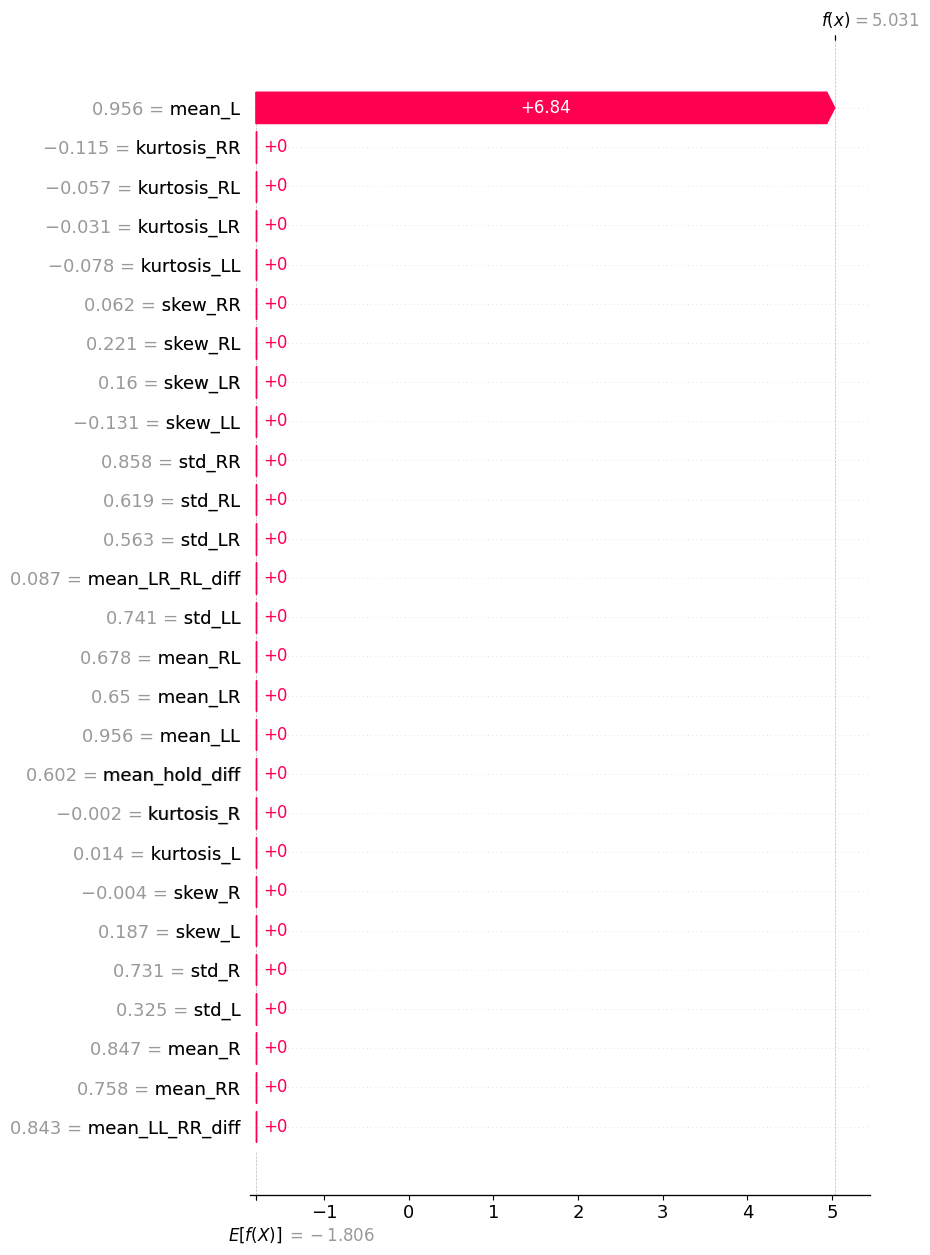

In [146]:
shap.plots.waterfall(shap_values[4], max_display=27)

In [147]:
shap.initjs()
shap.plots.force(shap_values[34])


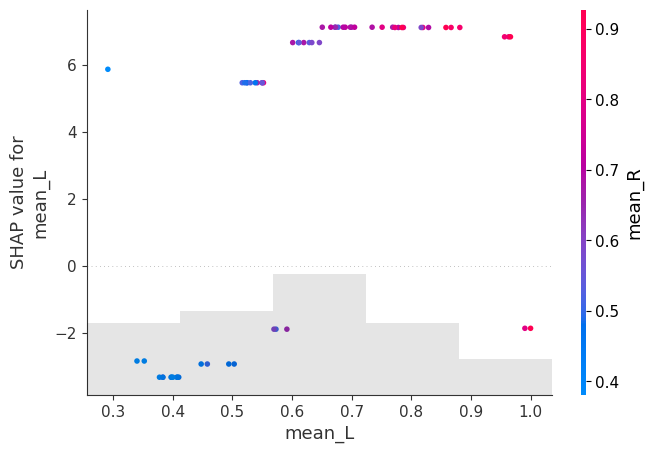

In [148]:
shap.plots.scatter(shap_values[:, 0], color=shap_values[:, 1])

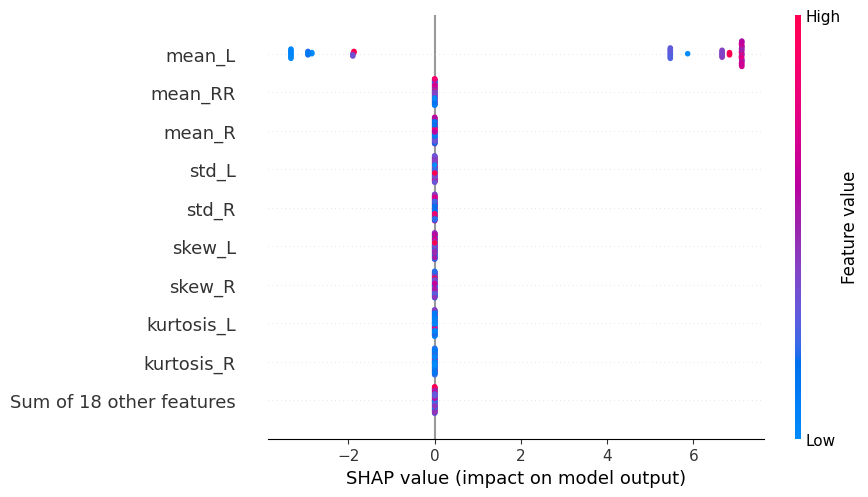

In [149]:
shap.plots.beeswarm(shap_values)